# PART 1 data cleaning 

### 1. Import the required packages

In [ ]:
## Import the required packages

# Basic operations
import pandas as pd
import numpy as np

# Data preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Data splitting
from sklearn.model_selection import train_test_split

# Data balancing
from imblearn.under_sampling import RandomUnderSampler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

# Model evaluation
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.metrics import confusion_matrix
# Model saving and loading
import joblib
from joblib import dump, load

# Explainability analysis
import shap


### 2. Read file

In [104]:
#   Read CSV file
df = pd.read_csv("../data/Complete_diabetes_prediction_dataset.csv")
df = pd.DataFrame(df)

In [105]:
#  View the first 5 rows of data
print(df.head())

   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  


In [106]:
# View basic information of data (including data types and missing values)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
None


In [107]:
# Descriptive statistics
print(df.describe())

                 age  hypertension  heart_disease            bmi  \
count  100000.000000  100000.00000  100000.000000  100000.000000   
mean       41.885856       0.07485       0.039420      27.320767   
std        22.516840       0.26315       0.194593       6.636783   
min         0.080000       0.00000       0.000000      10.010000   
25%        24.000000       0.00000       0.000000      23.630000   
50%        43.000000       0.00000       0.000000      27.320000   
75%        60.000000       0.00000       0.000000      29.580000   
max        80.000000       1.00000       1.000000      95.690000   

         HbA1c_level  blood_glucose_level       diabetes  
count  100000.000000        100000.000000  100000.000000  
mean        5.527507           138.058060       0.085000  
std         1.070672            40.708136       0.278883  
min         3.500000            80.000000       0.000000  
25%         4.800000           100.000000       0.000000  
50%         5.800000           14

### 3. Check for missing values

In [108]:
# Check for missing values in each column
print(df.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


### 4. Check for duplicate values

In [109]:
#  Check for duplicate values in the data box
duplicate_rows = df[df.duplicated()]

#  Display all duplicate rows
print(duplicate_rows)

       gender   age  hypertension  heart_disease smoking_history    bmi  \
2756     Male  80.0             0              0         No Info  27.32   
3272   Female  80.0             0              0         No Info  27.32   
3418   Female  19.0             0              0         No Info  27.32   
3939   Female  78.0             1              0          former  27.32   
3960     Male  47.0             0              0         No Info  27.32   
...       ...   ...           ...            ...             ...    ...   
99980  Female  52.0             0              0           never  27.32   
99985    Male  25.0             0              0         No Info  27.32   
99989  Female  26.0             0              0         No Info  27.32   
99990    Male  39.0             0              0         No Info  27.32   
99995  Female  80.0             0              0         No Info  27.32   

       HbA1c_level  blood_glucose_level  diabetes  
2756           6.6                  159        

In [110]:
# Delete all duplicate rows, retaining only the first one that appears
df = df.drop_duplicates()

In [111]:
#  Check for duplicate values in the data box
duplicate_rows = df[df.duplicated()]

#  Display all duplicate rows
print(duplicate_rows)

Empty DataFrame
Columns: [gender, age, hypertension, heart_disease, smoking_history, bmi, HbA1c_level, blood_glucose_level, diabetes]
Index: []


In [112]:
# 检查是否还有重复值
duplicates_remaining = df.duplicated().sum()
print(f"Number of duplicate rows remaining: {duplicates_remaining}")


Number of duplicate rows remaining: 0


### 5. Handling Extreme Values

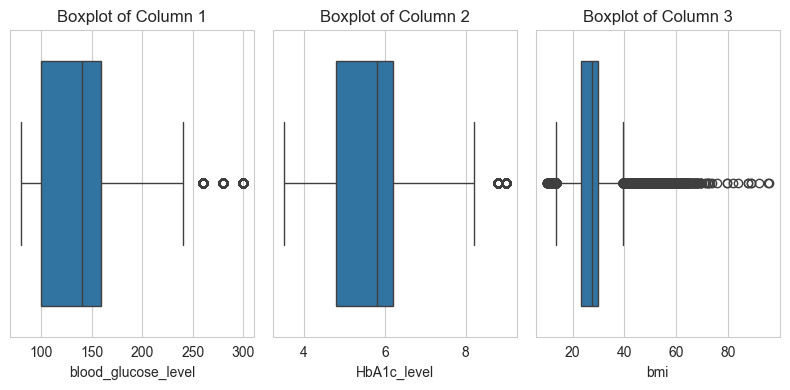

In [ ]:
# Create a layout with 1 row and 3 columns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 4))

# Draw the first boxplot
sns.boxplot(x=df['blood_glucose_level'], ax=axes[0])
axes[0].set_title('Boxplot of Column 1')

# Draw the second boxplot
sns.boxplot(x=df['HbA1c_level'], ax=axes[1])
axes[1].set_title('Boxplot of Column 2')

# Draw the third boxplot
sns.boxplot(x=df['bmi'], ax=axes[2])
axes[2].set_title('Boxplot of Column 3')

# Automatically adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# Function to calculate and print outliers
def calculate_outliers(column):
    data = df[column]
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return len(outliers), len(data)

# Analyze each feature
columns = ['blood_glucose_level', 'HbA1c_level', 'bmi']
for col in columns:
    outlier_count, total = calculate_outliers(col)
    print(f"{col}:")
    print(f"The number of outlier: {outlier_count}")
    print(f"Percentage of outlier : {outlier_count/total*100:.2f}%")
    print("-"*30)


blood_glucose_level:
The number of outlier: 2031
Percentage of outlier : 2.11%
------------------------------
HbA1c_level:
The number of outlier: 1312
Percentage of outlier : 1.36%
------------------------------
bmi:
The number of outlier: 5354
Percentage of outlier : 5.57%
------------------------------


In [ ]:
# Assuming your column name in the DataFrame is 'tension'
Q1 = df['HbA1c_level'].quantile(0.25)
Q3 = df['HbA1c_level'].quantile(0.75)
IQR = Q3 - Q1

# Calculate the upper and lower boundaries
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

# Replace outliers with the median
df.loc[df['HbA1c_level'] > upper_bound, 'HbA1c_level'] = df['HbA1c_level'].median()
df.loc[df['HbA1c_level'] < lower_bound, 'HbA1c_level'] = df['HbA1c_level'].median()


In [ ]:
# Assuming your column name in the DataFrame is 'hypertension'
Q1 = df['bmi'].quantile(0.25)
Q3 = df['bmi'].quantile(0.75)
IQR = Q3 - Q1

# Calculate the upper and lower boundaries
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

# Replace outliers with the median
df.loc[df['bmi'] > upper_bound, 'bmi'] = df['bmi'].median()
df.loc[df['bmi'] < lower_bound, 'bmi'] = df['bmi'].median()


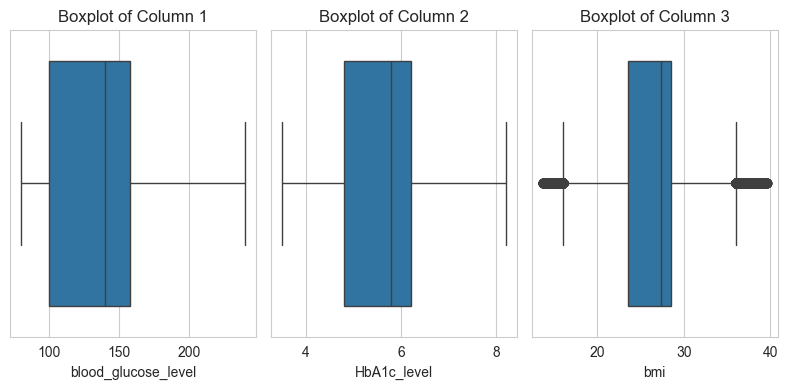

In [ ]:
# Create a layout with 1 row and 3 columns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8,4))

# Draw the first boxplot
sns.boxplot(x=df['blood_glucose_level'], ax=axes[0])
axes[0].set_title('Boxplot of Column 1')

# Draw the second boxplot
sns.boxplot(x=df['HbA1c_level'], ax=axes[1])
axes[1].set_title('Boxplot of Column 2')

# Draw the third boxplot
sns.boxplot(x=df['bmi'], ax=axes[2])
axes[2].set_title('Boxplot of Column 3')

# Automatically adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


### 6. One-Hot Encoding Transformation

In [ ]:
# Create an instance of OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)  # The old parameter sparse=False has been replaced

# Transform the 'gender' and 'smoking_history' columns into one-hot encoding
encoded_gender_smoking = encoder.fit_transform(df[['gender', 'smoking_history']])

# Convert the encoded data to a DataFrame and add column names
encoded_df = pd.DataFrame(encoded_gender_smoking, 
                          columns=encoder.get_feature_names_out(['gender', 'smoking_history']))

# Concatenate the original DataFrame and the encoded DataFrame
df = pd.concat([df, encoded_df], axis=1)

# Drop the 'gender' and 'smoking_history' columns
df = df.drop(['gender', 'smoking_history'], axis=1)

# Print the merged DataFrame
print(df)


        age  hypertension  heart_disease    bmi  HbA1c_level  \
0      80.0           0.0            1.0  25.19          6.6   
1      54.0           0.0            0.0  27.32          6.6   
2      28.0           0.0            0.0  27.32          5.7   
3      36.0           0.0            0.0  23.45          5.0   
4      76.0           1.0            1.0  20.14          4.8   
...     ...           ...            ...    ...          ...   
96076   NaN           NaN            NaN    NaN          NaN   
96085   NaN           NaN            NaN    NaN          NaN   
96125   NaN           NaN            NaN    NaN          NaN   
96126   NaN           NaN            NaN    NaN          NaN   
96133   NaN           NaN            NaN    NaN          NaN   

       blood_glucose_level  diabetes  gender_Female  gender_Male  \
0                    140.0       0.0            1.0          0.0   
1                     80.0       0.0            1.0          0.0   
2                    158.0 

In [ ]:
# Check for missing values in each column
print(df.isnull().sum())

age                            3585
hypertension                   3585
heart_disease                  3585
bmi                            3585
HbA1c_level                    3585
blood_glucose_level            3585
diabetes                       3585
gender_Female                  3585
gender_Male                    3585
gender_Other                   3585
smoking_history_No Info        3585
smoking_history_current        3585
smoking_history_ever           3585
smoking_history_former         3585
smoking_history_never          3585
smoking_history_not current    3585
dtype: int64


In [90]:
df= df.dropna(axis=0, how='any')

In [ ]:
# Check for missing values in each column
print(df.isnull().sum())


age                            0
hypertension                   0
heart_disease                  0
bmi                            0
HbA1c_level                    0
blood_glucose_level            0
diabetes                       0
gender_Female                  0
gender_Male                    0
gender_Other                   0
smoking_history_No Info        0
smoking_history_current        0
smoking_history_ever           0
smoking_history_former         0
smoking_history_never          0
smoking_history_not current    0
dtype: int64


In [ ]:
# View basic information about the data (including data types and missing values)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 92561 entries, 0 to 96145
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          92561 non-null  float64
 1   hypertension                 92561 non-null  float64
 2   heart_disease                92561 non-null  float64
 3   bmi                          92561 non-null  float64
 4   HbA1c_level                  92561 non-null  float64
 5   blood_glucose_level          92561 non-null  float64
 6   diabetes                     92561 non-null  float64
 7   gender_Female                92561 non-null  float64
 8   gender_Male                  92561 non-null  float64
 9   gender_Other                 92561 non-null  float64
 10  smoking_history_No Info      92561 non-null  float64
 11  smoking_history_current      92561 non-null  float64
 12  smoking_history_ever         92561 non-null  float64
 13  smoking_history_forme

In [ ]:
# Descriptive statistics
print(df.describe())

                age  hypertension  heart_disease           bmi   HbA1c_level  \
count  92561.000000  92561.000000   92561.000000  92561.000000  92561.000000   
mean      41.779180      0.077376       0.040600     26.462067      5.489233   
std       22.462138      0.267189       0.197363      5.085449      0.998316   
min        0.080000      0.000000       0.000000     13.710000      3.500000   
25%       24.000000      0.000000       0.000000     23.510000      4.800000   
50%       43.000000      0.000000       0.000000     27.320000      5.800000   
75%       59.000000      0.000000       0.000000     28.460000      6.200000   
max       80.000000      1.000000       1.000000     39.550000      8.200000   

       blood_glucose_level      diabetes  gender_Female   gender_Male  \
count         92561.000000  92561.000000   92561.000000  92561.000000   
mean            135.215955      0.088115       0.584123      0.415693   
std              35.092571      0.283463       0.492875     

In [ ]:
# Get all column names
columns = df.columns.tolist()

# Move the 7th column (index 6) to the last column
columns = columns[:6] + columns[7:] + [columns[6]]

# Rearrange the column order
df = df[columns]

C:\Users\29548\AppData\Local\Temp\ipykernel_40580\1607503188.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')


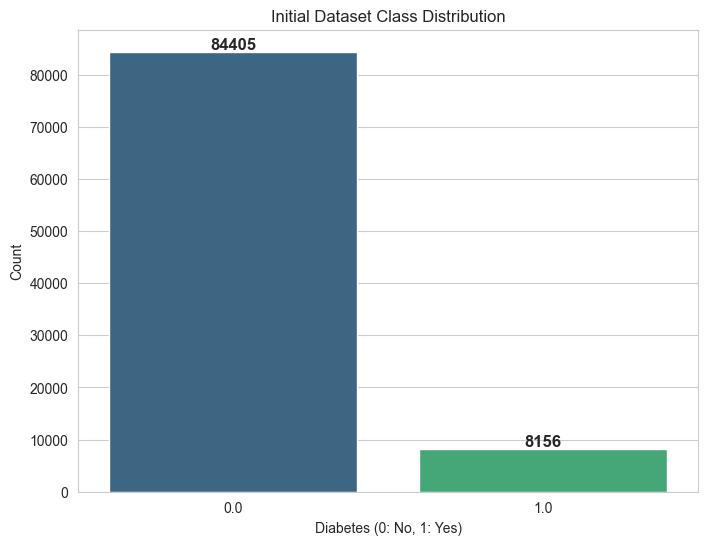

In [ ]:
# Calculate the distribution of the target variable
class_distribution = df['diabetes'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')

# Add value labels above each bar
for i, value in enumerate(class_distribution.values):
    plt.text(i, value + 500, str(value), ha='center', fontsize=12, fontweight='bold')

# Set title and labels
plt.title('Initial Dataset Class Distribution')
plt.xlabel('Diabetes (0: No, 1: Yes)')
plt.ylabel('Count')

# Display the plot
plt.show()


C:\Users\29548\AppData\Local\Temp\ipykernel_40580\61497476.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df_resampled['diabetes'], palette='viridis')


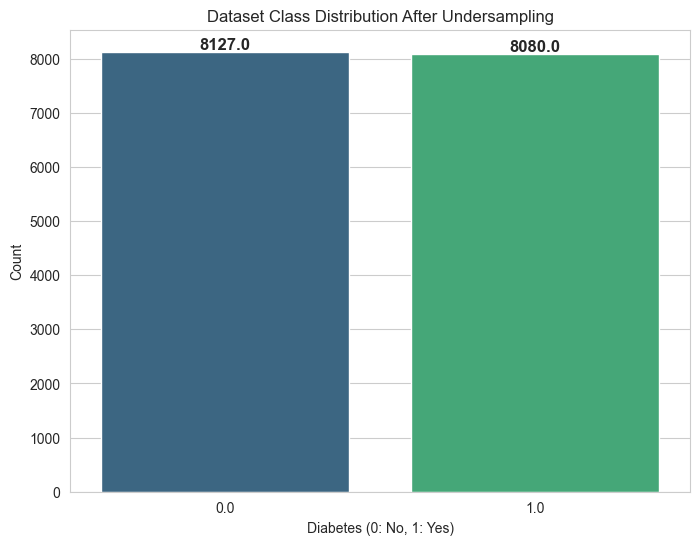

In [ ]:
# 1. Preprocess data
X = df.drop('diabetes', axis=1)  # Features
y = df['diabetes']  # Target variable

# 2. Perform random undersampling
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# 3. Combine into a new DataFrame
df_resampled = pd.concat([pd.DataFrame(X_resampled), pd.Series(y_resampled, name='diabetes')], axis=1)

# 4. Remove duplicate samples
df_resampled = df_resampled.drop_duplicates()

# 5. Visualize class distribution after undersampling
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=df_resampled['diabetes'], palette='viridis')

# Add value labels above each bar
for p in ax.patches:
    height = p.get_height()  # Get the height of the bar (sample count)
    ax.text(p.get_x() + p.get_width() / 2, height + 50, str(height), 
            ha='center', fontsize=12, fontweight='bold')

# Set title and labels
plt.title('Dataset Class Distribution After Undersampling')
plt.xlabel('Diabetes (0: No, 1: Yes)')
plt.ylabel('Count')

# Display the plot
plt.show()


In [ ]:
# Count the number of samples for each category after removing duplicates
class_counts = df_resampled['diabetes'].value_counts()

# Print the sample size for each category
print("Sample size for each category:")
print(class_counts)


每个类别的样本数量：
diabetes
0.0    8127
1.0    8080
Name: count, dtype: int64


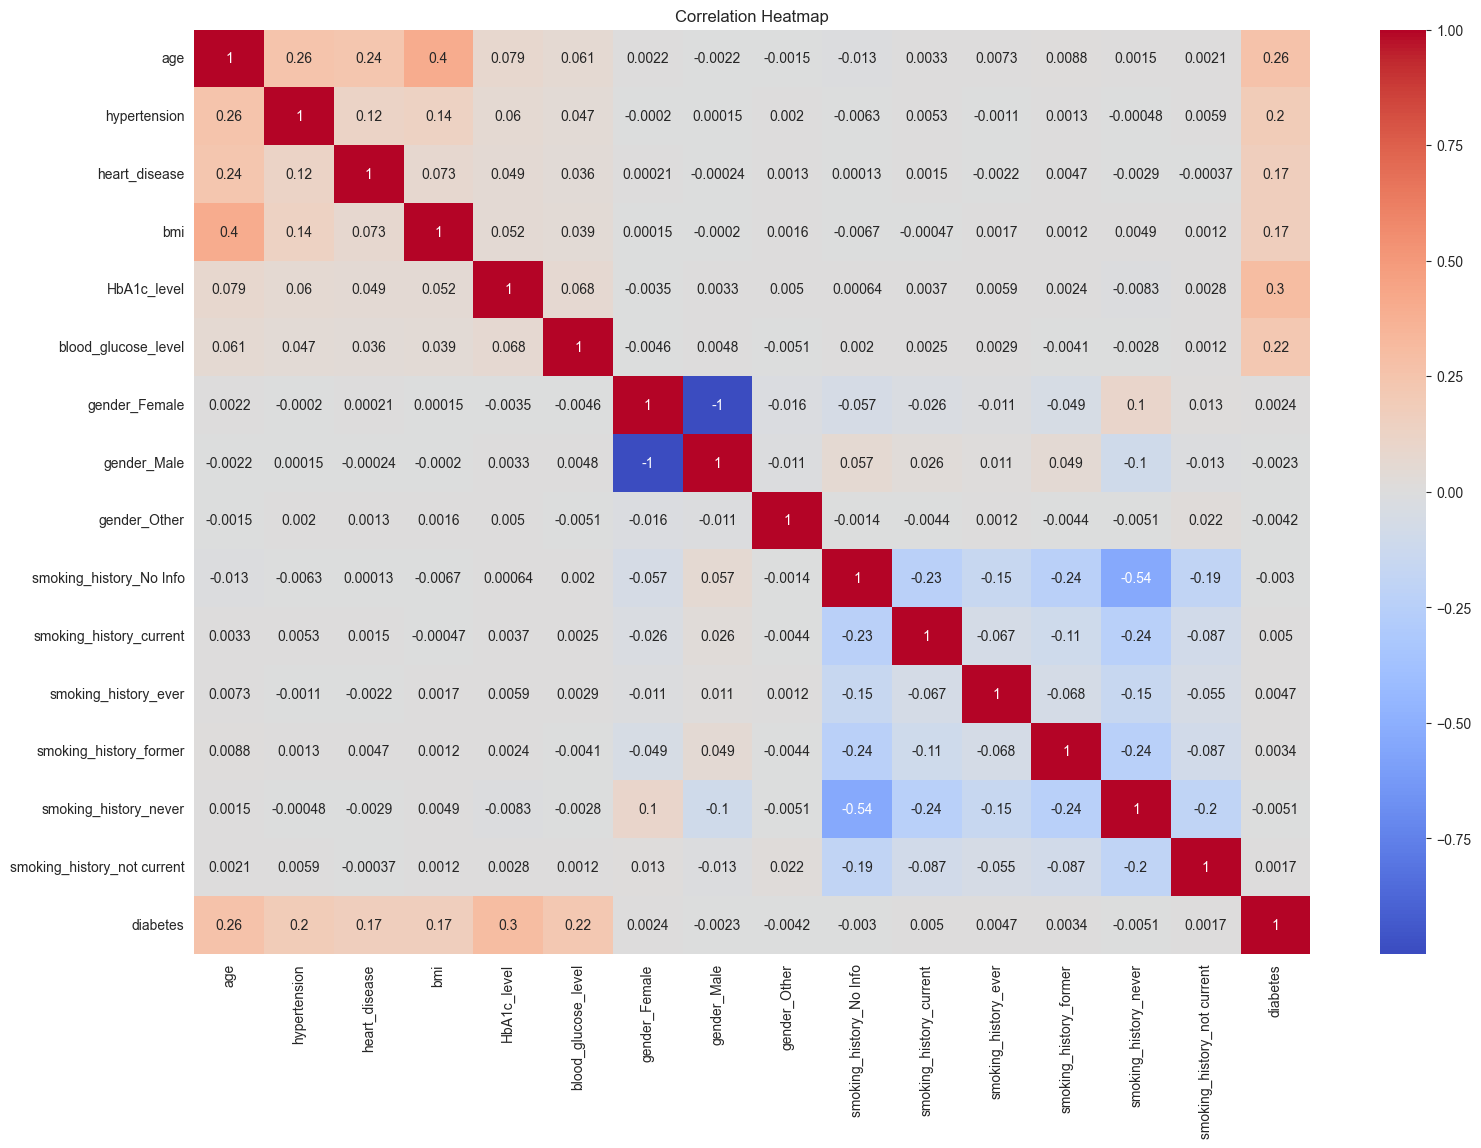

In [71]:
plt.figure(figsize=(18, 12))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
X = df_resampled.iloc[:, :-1]  # Features
y = df_resampled.iloc[:, -1]   # Labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Recombine into complete datasets
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# Save the split datasets
train_data.to_csv("../data/train_data.csv", index=False)
test_data.to_csv("../data/test_data.csv", index=False)

print("save as train_dataset.csv and test_dataset.csv")


save as train_dataset.csv and test_dataset.csv


# Part2: Modelling 

## 1. Import training and testing sets

In [ ]:

# Import training dataset
train_df = pd.read_csv('../data/train_data.csv')
Y_train = train_df['diabetes']  # Target variable for training dataset
X_train = train_df.iloc[:, :-1]  # Select all rows and all columns except the last one

# Import testing dataset 
test_df = pd.read_csv('../data/test_data.csv')
Y_test = test_df['diabetes']  # Target variable for testing dataset
X_test = test_df.iloc[:, :-1]  # Select all rows and all columns except the last one

In [ ]:
# Output the result
print("Training dataset features:", X_train.shape)  
print("Testing dataset features:", X_test.shape)  
print("Training dataset target:", Y_train.shape)  
print("Testing dataset target:", Y_test.shape)

Training dataset features: (12965, 15)
Testing dataset features: (3242, 15)
Training dataset target: (12965,)
Testing dataset target: (3242,)


In [ ]:
# Assuming X_train and X_test are already split training and testing sets (DataFrame format)

# Save the column names
columns = X_train.columns

# Initialize StandardScaler
scaler = StandardScaler()

# Standardize the training set (fit + transform)
X_train = scaler.fit_transform(X_train)

# Standardize the test set (only transform, to avoid data leakage)
X_test = scaler.transform(X_test)

# Convert back to DataFrame and specify column names
X_train = pd.DataFrame(X_train, columns=columns)
X_test = pd.DataFrame(X_test, columns=columns)


In [ ]:
# Output the shape of the standardized data
print("Standardized Training dataset features:", X_train.shape)
print("Standardized Testing dataset features:", X_test.shape)

# Print the first five rows of the standardized training and testing sets
print("\nStandardized Training Data (First 5 rows):")
print(X_train.head())

print("\nStandardized Testing Data (First 5 rows):")
print(X_test.head())


Standardized Training dataset features: (12965, 15)
Standardized Testing dataset features: (3242, 15)

Standardized Training Data (First 5 rows):
        age  hypertension  heart_disease       bmi  HbA1c_level  \
0  0.017017     -0.430485      -0.317608  0.730781     0.272778   
1 -2.089375     -0.430485      -0.317608 -2.167479     0.174079   
2 -1.434053     -0.430485      -0.317608 -0.099294     0.568873   
3  0.999999     -0.430485      -0.317608  0.296742     1.062365   
4 -1.902140     -0.430485      -0.317608 -0.099294     0.272778   

   blood_glucose_level  gender_Female  gender_Male  gender_Other  \
0            -1.272030       0.841661    -0.841661           0.0   
1             1.448857      -1.188126     1.188126           0.0   
2             0.333293       0.841661    -0.841661           0.0   
3             0.360502       0.841661    -0.841661           0.0   
4            -0.047631       0.841661    -0.841661           0.0   

   smoking_history_No Info  smoking_histor

In [ ]:
# Check for duplicate rows between training and testing sets
duplicates = X_train.index.isin(X_test.index)
print("Number of duplicate samples:", sum(duplicates))

Number of duplicate samples: 3242


In [ ]:
# Remove duplicate rows (synchronize X_train and Y_train)
X_train = X_train[~duplicates]
Y_train = Y_train[~duplicates]

In [ ]:
# Check for duplicate rows between the training and testing sets
duplicates = X_train.index.isin(X_test.index)
print("Number of duplicate samples:", sum(duplicates))

Number of duplicate samples: 0


In [ ]:
# Output the shape of the standardized data
print("Standardized Training dataset features:", X_train.shape)
print("Standardized Testing dataset features:", X_test.shape)

# Print the first five rows of the standardized training and testing sets
print("\nStandardized Training Data (First 5 rows):")
print(X_train.head())

print("\nStandardized Testing Data (First 5 rows):")
print(X_test.head())


Standardized Training dataset features: (9723, 15)
Standardized Testing dataset features: (3242, 15)

Standardized Training Data (First 5 rows):
           age  hypertension  heart_disease       bmi  HbA1c_level  \
3242  0.251060      2.322962      -0.317608  1.138817    -0.122016   
3243 -1.340436     -0.430485      -0.317608  0.864793     0.864969   
3244 -1.527670     -0.430485      -0.317608 -0.419323    -1.405096   
3245 -0.497879      2.322962      -0.317608 -0.099294     0.568873   
3246  0.251060      2.322962      -0.317608  0.820789     0.864969   

      blood_glucose_level  gender_Female  gender_Male  gender_Other  \
3242             2.537212       0.841661    -0.841661           0.0   
3243            -0.183675      -1.188126     1.188126           0.0   
3244             0.224458       0.841661    -0.841661           0.0   
3245            -1.544118       0.841661    -0.841661           0.0   
3246            -0.183675       0.841661    -0.841661           0.0   

      s

## 2. Model selection and training
Firstly we will select the right algorithm according to our requirement and then we will train data on model

In [ ]:
# Define the configurations for all models (name, model class, parameters)
model_configs = [
    {
        'name': 'Random Forest',
        'class': RandomForestClassifier,
        'params': {'n_estimators': 50, 
                   'random_state': 5, 
                   'max_depth' : 2,
                   'min_samples_split':2,
                   'min_samples_leaf':4}
    },
    {
        'name': 'AdaBoost',
        'class': AdaBoostClassifier,
        'params': {'n_estimators': 30, 'random_state': 5}
    },
    {
        'name': 'XGBoost',
        'class': XGBClassifier,
        'params': {'n_estimators': 50, 'random_state': 42}
    }, 
    {
        'name': 'CatBoost',
        'class': CatBoostClassifier,
        'params': {'iterations': 50, 'learning_rate': 0.1, 'depth': 6, 'random_state': 42, 'verbose': 0}
    }
]

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train and evaluate each model consistently
for config in model_configs:
    model_name = config['name']
    model = config['class'](**config['params'])
    
    # Train the model
    model.fit(X_train, Y_train)
    
    # Predict on the training set
    Y_pred_train = model.predict(X_train)  
    
    # Calculate metrics for the training set
    acc_train = accuracy_score(Y_train, Y_pred_train)  
    pre_train = precision_score(Y_train, Y_pred_train, average='weighted')  
    rec_train = recall_score(Y_train, Y_pred_train, average='weighted')  # Calculate recall
    f1_train = f1_score(Y_train, Y_pred_train, average='weighted')  
    
    # Print results (compare training and test sets)
    print(f"\n=== {model_name} ===")
    print("[train] Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-Score: {:.4f}".format(acc_train, pre_train, rec_train, f1_train))


=== Random Forest ===
[train] Accuracy: 0.8611, Precision: 0.8640, Recall: 0.8611, F1-Score: 0.8608

=== AdaBoost ===
[train] Accuracy: 0.8923, Precision: 0.8937, Recall: 0.8923, F1-Score: 0.8922

=== XGBoost ===
[train] Accuracy: 0.9288, Precision: 0.9302, Recall: 0.9288, F1-Score: 0.9288


c:\Users\29548\anaconda3\envs\tf\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



=== CatBoost ===
[train] Accuracy: 0.8963, Precision: 0.8994, Recall: 0.8963, F1-Score: 0.8961


In [ ]:
# Iterate over all model configurations
for config in model_configs:
    model_name = config['name']
    model = config['class'](**config['params'])
    
    # Train the model
    model.fit(X_train, Y_train)
    
    # Save the model
    joblib.dump(model, f'{model_name.lower().replace(" ", "_")}_model.pkl')
    print(f"Model {model_name} saved successfully.")


Model Random Forest saved successfully.
Model AdaBoost saved successfully.


c:\Users\29548\anaconda3\envs\tf\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model Gradient Boosting saved successfully.
Model XGBoost saved successfully.
Model CatBoost saved successfully.


## 3. Model Testing 

In [ ]:
# Iterate over all model configurations
for config in model_configs:
    model_name = config['name']
    
    # Load the saved best model
    best_model = joblib.load(f'{model_name.lower().replace(" ", "_")}_model.pkl')
    
    # Predict using the best model (test set)
    Y_pred_test = best_model.predict(X_test)
    
    # Predict using the best model (train set)
    Y_pred_train = best_model.predict(X_train)
    
    # Calculate metrics for the test set
    acc_test = accuracy_score(Y_test, Y_pred_test)
    pre_test = precision_score(Y_test, Y_pred_test, average='weighted')
    rec_test = recall_score(Y_test, Y_pred_test, average='weighted')  # Recall
    f1_test = f1_score(Y_test, Y_pred_test, average='weighted')
    
    # Calculate metrics for the training set
    acc_train = accuracy_score(Y_train, Y_pred_train)
    pre_train = precision_score(Y_train, Y_pred_train, average='weighted')
    rec_train = recall_score(Y_train, Y_pred_train, average='weighted')  # Recall
    f1_train = f1_score(Y_train, Y_pred_train, average='weighted')
    
    # Print results
    print(f"\n=== {model_name} ===")
    print("[test data] Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-Score: {:.4f}".format(acc_test, pre_test, rec_test, f1_test))


=== Random Forest ===
[test data] Accuracy: 0.8510, Precision: 0.8538, Recall: 0.8510, F1-Score: 0.8507

=== AdaBoost ===
[test data] Accuracy: 0.8846, Precision: 0.8865, Recall: 0.8846, F1-Score: 0.8845

=== XGBoost ===
[test data] Accuracy: 0.8868, Precision: 0.8888, Recall: 0.8868, F1-Score: 0.8866

=== CatBoost ===
[test data] Accuracy: 0.8871, Precision: 0.8912, Recall: 0.8871, F1-Score: 0.8868


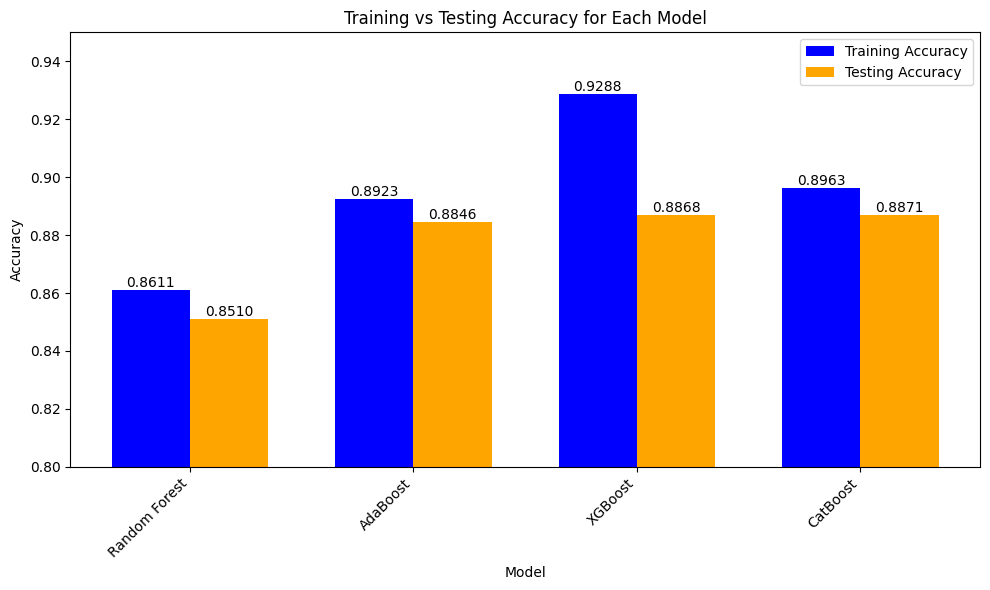

In [ ]:
# Store model names and corresponding accuracies
model_names = []
train_accuracies = []
test_accuracies = []

# Iterate over all model configurations
for config in model_configs:
    model_name = config['name']
    model_names.append(model_name)
    
    # Load the saved best model
    best_model = joblib.load(f'{model_name.lower().replace(" ", "_")}_model.pkl')
    
    # Predict
    Y_pred_test = best_model.predict(X_test)
    Y_pred_train = best_model.predict(X_train)
    
    # Calculate accuracies
    acc_test = accuracy_score(Y_test, Y_pred_test)
    acc_train = accuracy_score(Y_train, Y_pred_train)
    
    # Record data
    train_accuracies.append(acc_train)
    test_accuracies.append(acc_test)

# Set up bar chart parameters
x = np.arange(len(model_names))  # X-axis tick positions
width = 0.35  # Bar width

# Create bar chart
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_accuracies, width, label='Training Accuracy', color='blue')
rects2 = ax.bar(x + width/2, test_accuracies, width, label='Testing Accuracy', color='orange')

# Add text and labels
ax.set_xlabel("Model")
ax.set_ylabel("Accuracy")

ax.set_ylim(0.8, 0.95)
ax.set_title("Training vs Testing Accuracy for Each Model")
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha="right")
ax.legend()

# Display value labels (up to four decimal places)
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, f'{height:.4f}', 
            ha='center', va='bottom')

# Show the chart
plt.tight_layout()
plt.show()


## 4. Combine into a Ensemble model

### Feature Extract

xgb cat meta

In [ ]:
# Load pre-trained models
catboost_model = joblib.load('catboost_model.pkl')
xgboost_model = joblib.load('xgboost_model.pkl')

# Define base learners (names must be unique)
base_learners = [
    ('catboost', catboost_model),
    ('xgboost', xgboost_model)
]

# Generate probability features (richer meta-features)
def extract_meta_features(models, X):
    meta_features = []
    for name, model in models:
        if hasattr(model, "predict_proba"):
            proba = model.predict_proba(X)
        else:
            # If the model does not support probability prediction, use class labels and one-hot encode
            pred = model.predict(X).reshape(-1, 1)
            proba = OneHotEncoder().fit_transform(pred).toarray()
        meta_features.append(proba)
    return np.hstack(meta_features)

# Extract meta-features for training and testing sets
X_train_2meta = extract_meta_features(base_learners, X_train)
X_test_2meta = extract_meta_features(base_learners, X_test)

# Option 1: Use meta features + raw features for training (requires passing through)
# Option 1: Train meta-learner using meta-features directly
meta_learner = LogisticRegression(solver='saga', penalty='l2', C=0.1)
ensemble_2model = meta_learner.fit(X_train_2meta, Y_train)

import pandas as pd

# Save the meta-features
pd.DataFrame(X_train_2meta).to_csv('X_train_2meta_new.csv', index=False)
pd.DataFrame(X_test_2meta).to_csv('X_test_2meta_new.csv', index=False)


In [ ]:
# Make predictions using the ensemble model
Y_train_pred = ensemble_2model.predict(X_train_2meta)
Y_test_pred = ensemble_2model.predict(X_test_2meta)

# Calculate training set metrics
train_acc = accuracy_score(Y_train, Y_train_pred)
train_pre = precision_score(Y_train, Y_train_pred, average='weighted')
train_rec = recall_score(Y_train, Y_train_pred, average='weighted')  # Recall
train_f1 = f1_score(Y_train, Y_train_pred, average='weighted')

# Calculate testing set metrics
test_acc = accuracy_score(Y_test, Y_test_pred)
test_pre = precision_score(Y_test, Y_test_pred, average='weighted')
test_rec = recall_score(Y_test, Y_test_pred, average='weighted')  # Recall
test_f1 = f1_score(Y_test, Y_test_pred, average='weighted')

# Print results
print(f"train- acc: {train_acc:.4f}, pre: {train_pre:.4f}, rec: {train_rec:.4f}, F1: {train_f1:.4f}")
print(f"test - acc: {test_acc:.4f}, pre: {test_pre:.4f}, rec: {test_rec:.4f}, F1: {test_f1:.4f}")


train- acc: 0.9298, pre: 0.9303, rec: 0.9298, F1: 0.9297
test - acc: 0.8893, pre: 0.8901, rec: 0.8893, F1: 0.8892


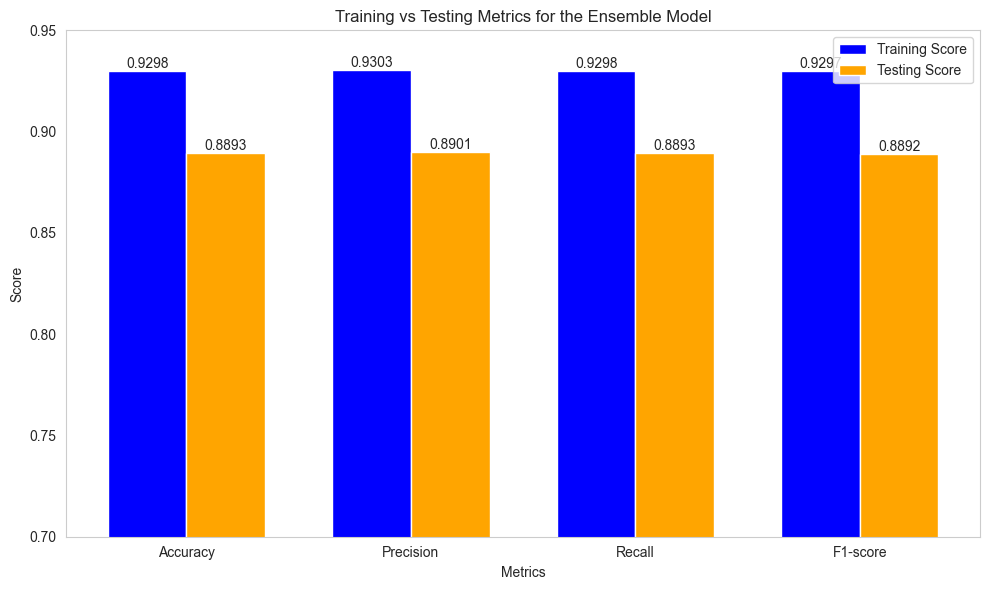

In [ ]:
# Metric names
metrics = ["Accuracy", "Precision", "Recall", "F1-score"]

# Training and testing score values (please replace with your actual data)
train_scores = [train_acc, train_pre, train_rec, train_f1]
test_scores = [test_acc, test_pre, test_rec, test_f1]

x = np.arange(len(metrics))  # X-axis positions
width = 0.35  # Bar width

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training Score', color='blue')
rects2 = ax.bar(x + width/2, test_scores, width, label='Testing Score', color='orange')

# Set labels
ax.set_xlabel("Metrics")
ax.set_ylabel("Score")
ax.set_ylim(0.7, 0.95)
ax.set_title("Training vs Testing Metrics for the Ensemble Model")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
# Remove background grid lines
ax.grid(False)  

# Display value labels
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, f'{height:.4f}',
            ha='center', va='bottom', fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()

In [15]:
ensemble_2model
joblib.dump(ensemble_2model, 'ensemble_2model.pkl')

['ensemble_2model.pkl']

C:\Users\29548\AppData\Local\Temp\ipykernel_20580\3735424688.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=model_names, y=accuracies, palette="viridis")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


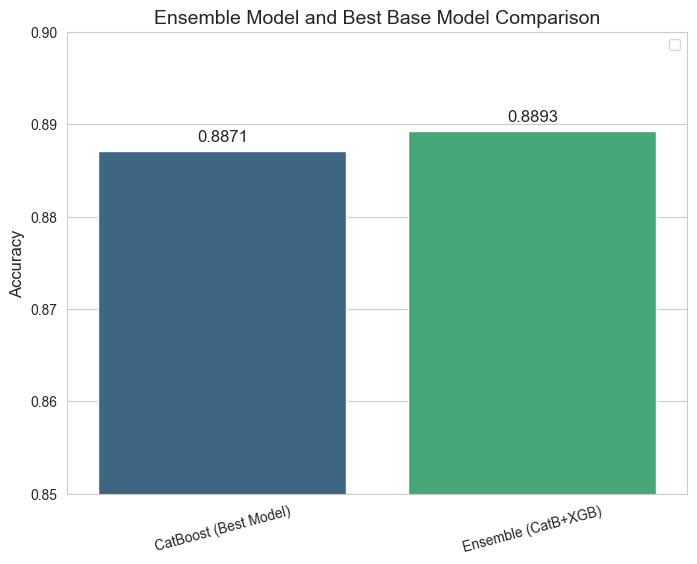

In [ ]:
# Calculate the predictions for XGBoost and Hybrid models
y_pred_catb = catboost_model.predict(X_test)  # Base model XGBoost
y_pred_h2 = ensemble_2model.predict(X_test_2meta)  # Ensemble-2 (XGB+CatB)

# Calculate accuracy
acc_xgb = accuracy_score(Y_test, y_pred_catb)
acc_h2 = accuracy_score(Y_test, y_pred_h2)
# acc_h3 = accuracy_score(Y_train, y_pred_h3)
# acc_h4 = accuracy_score(Y_train, y_pred_h4)

# Create data
model_names = ['CatBoost (Best Model)', 'Ensemble (CatB+XGB)']
accuracies = [acc_xgb, acc_h2]

# Set Seaborn style
sns.set_style("whitegrid")

# Create the figure
plt.figure(figsize=(8, 6))

# Plot bar chart
barplot = sns.barplot(x=model_names, y=accuracies, palette="viridis")

# Get the x coordinates of each bar
x_positions = [p.get_x() + p.get_width() / 2 for p in barplot.patches]

# # Plot line (optional)
# plt.plot(x_positions, accuracies, marker='o', color='r', linestyle='-', linewidth=2, markersize=8, label="Accuracy Trend")

# Add value annotations
for i, v in enumerate(accuracies):
    plt.text(x_positions[i], v + 0.001, f"{v:.4f}", ha='center', fontsize=12)

# Beautify the chart
plt.title("Ensemble Model and Best Base Model Comparison", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0.85, 0.90)  # Set y-axis range
plt.xticks(rotation=15)  # Rotate labels to avoid overlap
plt.legend()  # Show legend
plt.show()


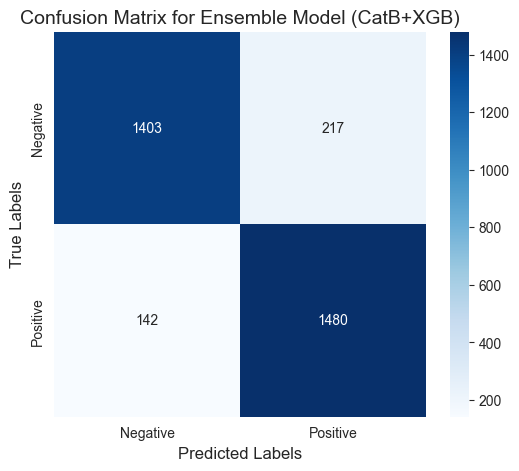

In [ ]:
# 计算混淆矩阵
cm_h2 = confusion_matrix(Y_test, y_pred_h2)

# 创建热力图
plt.figure(figsize=(6, 5))
sns.heatmap(cm_h2, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

# 添加标签
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix for Ensemble Model (CatB+XGB)", fontsize=14)

# 显示图像
plt.show()

# Calculate the confusion matrix
cm_h2 = confusion_matrix(Y_test, y_pred_h2)

# Create a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm_h2, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

# Add labels
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix for Ensemble Model (CatB+XGB)", fontsize=14)

# Display the image
plt.show()


In [ ]:
# Calculate test set metrics
test_acc = accuracy_score(Y_test, y_pred_h2)
test_pre = precision_score(Y_test, y_pred_h2, average='weighted')
test_rec = recall_score(Y_test, y_pred_h2, average='weighted')  # Recall
test_f1 = f1_score(Y_test, y_pred_h2, average='weighted')

print(f"test - acc: {test_acc:.4f}, pre: {test_pre:.4f}, rec: {test_rec:.4f}, F1: {test_f1:.4f}")

test - acc: 0.8893, pre: 0.8901, rec: 0.8893, F1: 0.8892


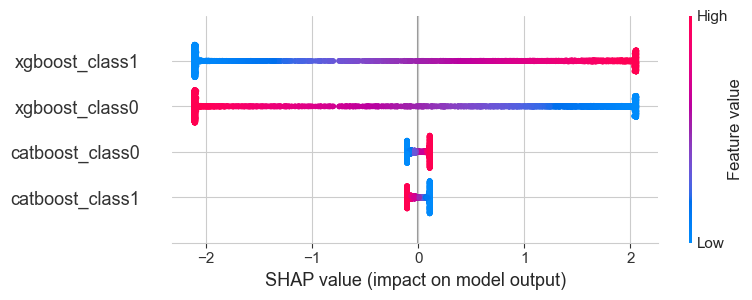

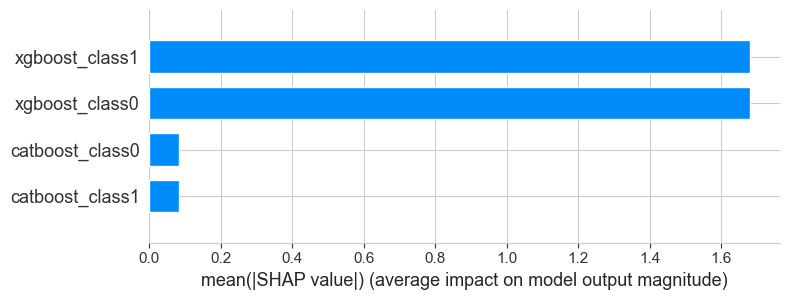

In [ ]:
# Define feature names
num_classes = X_train_2meta.shape[1] // len(base_learners)  # Assuming all models have the same number of classes
feature_names = []

for i, (name, model) in enumerate(base_learners):
    for j in range(num_classes):
        feature_names.append(f"{name}_class{j}")

# Convert to DataFrame and assign column names
X_train_2meta_df = pd.DataFrame(X_train_2meta, columns=feature_names)
X_test_2meta_df = pd.DataFrame(X_test_2meta, columns=feature_names)

# Recalculate SHAP values
explainer = shap.Explainer(ensemble_2model, X_test_2meta_df)
shap_values = explainer(X_test_2meta_df)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test_2meta_df)
shap.summary_plot(shap_values, X_test_2meta_df, plot_type="bar")


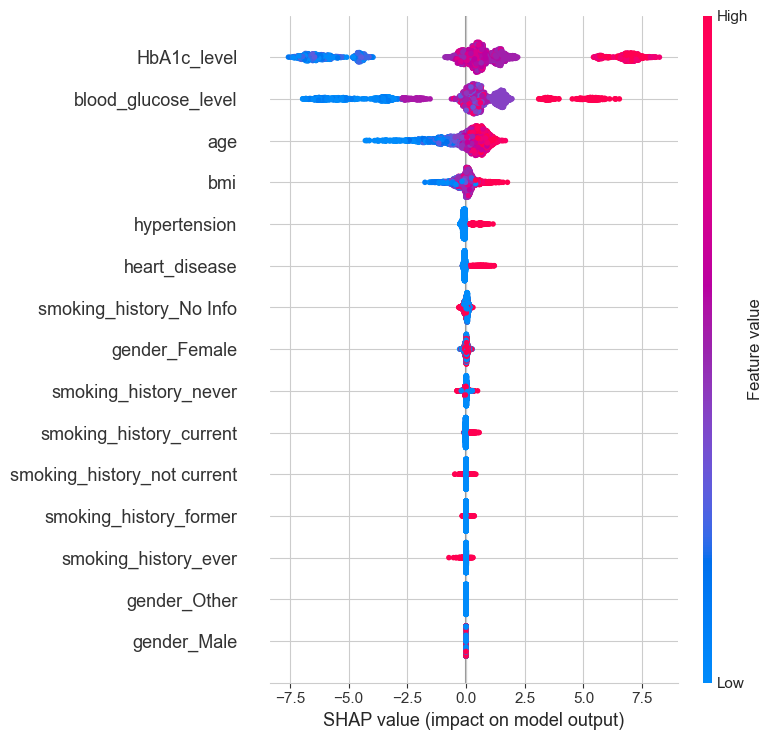

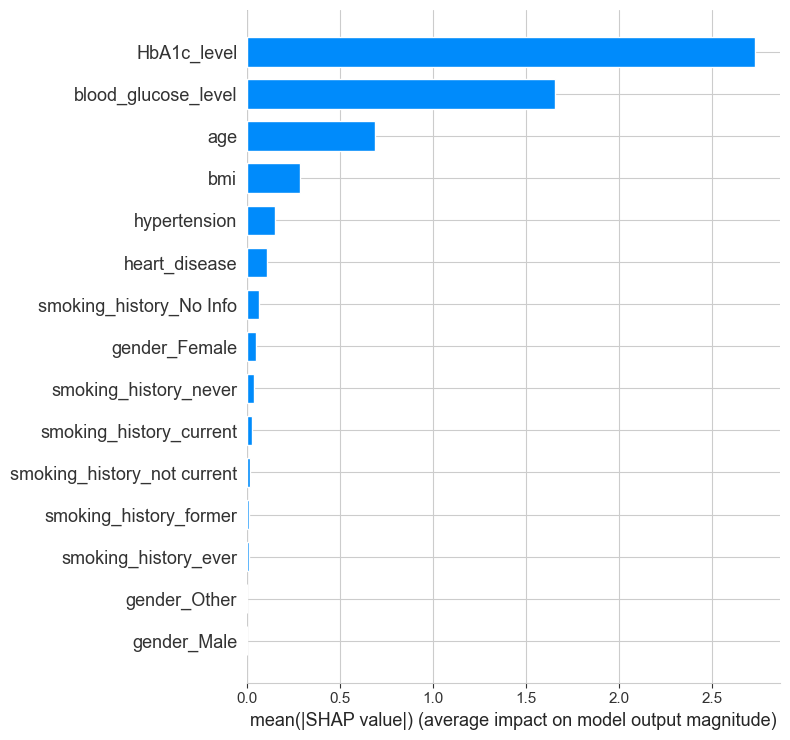

In [24]:
# Initialize SHAP explainer for the hybrid model
explainer = shap.Explainer(xgboost_model, X_test)

# Compute SHAP values
shap_values = explainer(X_test)

# Summary plot (Feature importance)
shap.summary_plot(shap_values, X_test)

# Bar plot (Feature importance ranking)
shap.summary_plot(shap_values, X_test, plot_type="bar")